In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from imblearn.over_sampling import SMOTE

In [5]:
df = pd.read_csv("UCI_Credit_Card.csv")
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [6]:
df.drop(["ID"], axis=1, inplace=True)
df['EDUCATION'] = df['EDUCATION'].replace({0: 1, 5: 1, 6: 1})
df['MARRIAGE'] = df['MARRIAGE'].replace({0: 1})

In [8]:
X = df.drop(['default.payment.next.month'], axis=1)
y = df['default.payment.next.month']

In [13]:
#Scaling

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [14]:
#Splitting

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [15]:
#Balancing the data

smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
print("Before oversampling:", dict(zip(*np.unique(y_train, return_counts=True))))
print("After oversampling:", dict(zip(*np.unique(y_train_balanced, return_counts=True))))

Before oversampling: {0: 18677, 1: 5323}
After oversampling: {0: 18677, 1: 18677}


In [18]:
#Train and evaluate Logistic Regression

logit_model = LogisticRegression(random_state=42)
logit_model.fit(X_train_balanced, y_train_balanced)
logit_pred = logit_model.predict(X_test)

print("Logistic Regression Results:")
print("Accuracy:", accuracy_score(y_test, logit_pred))
print("\nClassification Report:")
print(classification_report(y_test, logit_pred))

Logistic Regression Results:
Accuracy: 0.6866666666666666

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.69      0.78      4687
           1       0.38      0.66      0.48      1313

    accuracy                           0.69      6000
   macro avg       0.63      0.68      0.63      6000
weighted avg       0.77      0.69      0.71      6000



In [19]:
#Train and evaluate Random Forest

rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_balanced, y_train_balanced)
rf_pred = rf_model.predict(X_test)

print("Random Forest Results:")
print("Accuracy:", accuracy_score(y_test, rf_pred))
print("\nClassification Report:")
print(classification_report(y_test, rf_pred))

Random Forest Results:
Accuracy: 0.7981666666666667

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.89      0.87      4687
           1       0.55      0.47      0.50      1313

    accuracy                           0.80      6000
   macro avg       0.70      0.68      0.69      6000
weighted avg       0.79      0.80      0.79      6000



In [20]:
#Train and evaluate XGBoost

xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train_balanced, y_train_balanced)
xgb_pred = xgb_model.predict(X_test)

print("XGBoost Results:")
print("Accuracy:", accuracy_score(y_test, xgb_pred))
print("\nClassification Report:")
print(classification_report(y_test, xgb_pred))

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:19:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Results:
Accuracy: 0.8018333333333333

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.91      0.88      4687
           1       0.56      0.42      0.48      1313

    accuracy                           0.80      6000
   macro avg       0.71      0.66      0.68      6000
weighted avg       0.79      0.80      0.79      6000



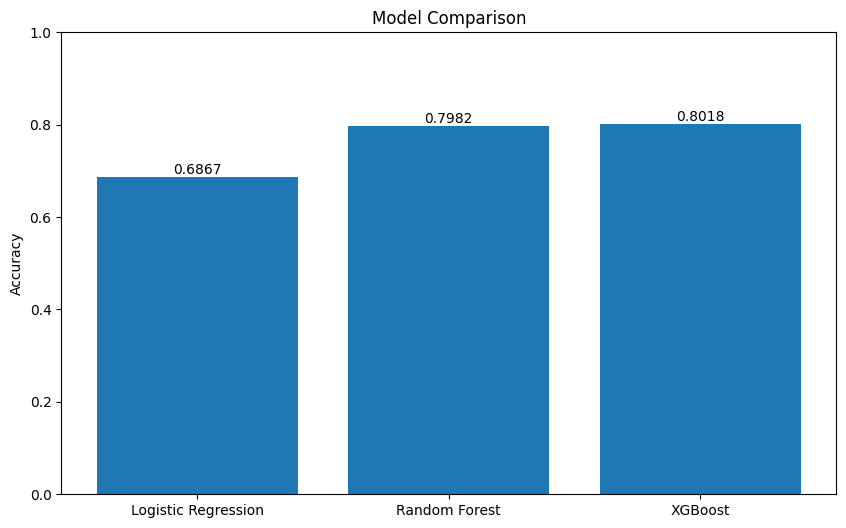

In [21]:
#Compare model performances

models = [logit_model, rf_model, xgb_model]
model_names = ['Logistic Regression', 'Random Forest', 'XGBoost']
accuracies = [accuracy_score(y_test, model.predict(X_test)) for model in models]

plt.figure(figsize=(10,6))
plt.bar(model_names, accuracies)
plt.title('Model Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
for i, v in enumerate(accuracies):
    plt.text(i, v, f'{v:.4f}', ha='center', va='bottom')
plt.show()

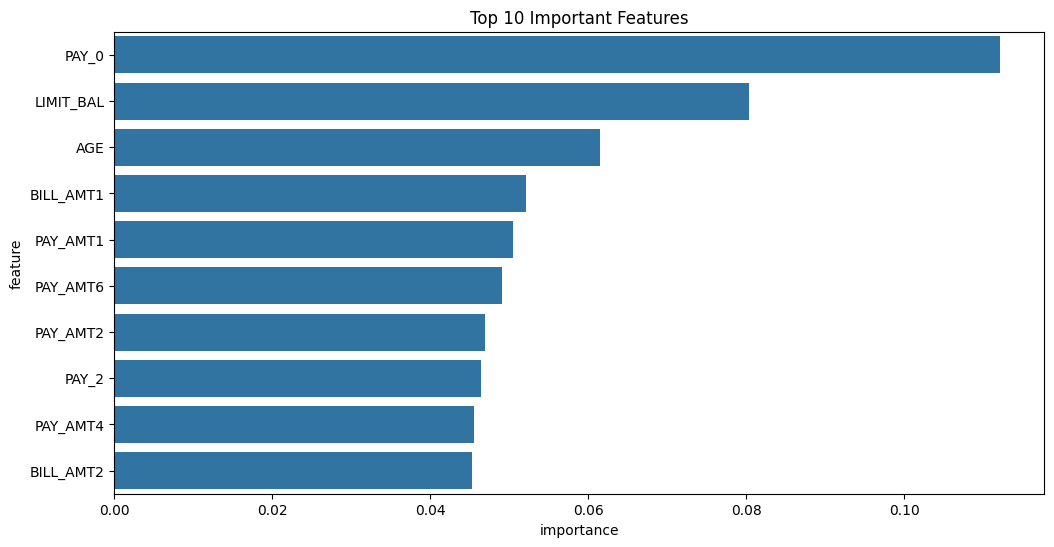

In [23]:
#Feature importance (using Random Forest as an example)

feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(x='importance', y='feature', data=feature_importance.head(10))
plt.title('Top 10 Important Features')
plt.show()